In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
%matplotlib inline
import VersionZeroPointZero as PSS
from scipy import signal

In [3]:
def Convolution(pulsar_object,input_array):
    """
    General convolution function. Takes an input array made in other functions
    to convolve with the pulse profile.
    
    Parameters
    ---
    pulsar_object: VersionZeroPointZero.pulsar.Pulsar object
        The pulsar object
    input_array: somewhere
        Any array the user wants to convolve with the pulse profile
    """
    
    width = pulsar_object.nBinsPeriod
    for ii, freq in enumerate(pulsar_object.Signal_in.freq_Array):
        #Normalizing the pulse profile
        pulsar_prof_sum = np.sum(pulsar_object.profile[ii,:])
        pulsar_prof_norm = pulsar_object.profile[ii,:] / pulsar_prof_sum
        
        #Normalizing the input array
        print(len(input_array))
        input_array_sum = np.sum(input_array[ii,:])
        input_array_norm = input_array[ii,:] / input_array_sum
        
        #Convolving the input array with the pulse profile
        convolved_prof = sp.convolve(pulsar_prof_norm, input_array_norm,"full")
        
        #Renormalizing the convolved pulse profile
        pulsar_object.profile[ii,:] = (pulsar_prof_sum)*(convolved_prof[:width])

In [4]:
def DMBroaden2(pulsar_object,signal_object):
    """
    This is a function that makes a top hat function.
    Calls general convolution function to convolve with pulse profile.
    See PATH/TO/CONVOLUTION for more information.
       
    Parameters
    ---------
    pulsar_object: VersionZeroPointZero.pulsar.Pulsar object
        The pulsar object 
    signal_object: VersionZeroPointZero.signal.Signal
        The signal object
    
    Notes
    -----
    Also records the DM widths in the MetaData of the signal object.
    """ 
    
    dm_widths = np.zeros(pulsar_object.Nf)
    lowest_freq_top_hat_width = int(PSS.utils.top_hat_width(pulsar_object.bw / pulsar_object.Nf, pulsar_object.Signal_in.freq_Array[0], 100) // pulsar_object.TimeBinSize)    
    tophat_array = np.zeros((pulsar_object.Nf,lowest_freq_top_hat_width))
    
    for ii, freq in enumerate(pulsar_object.Signal_in.freq_Array):
        #Creating the top hat array
        
        sub_band_width = pulsar_object.bw / pulsar_object.Nf
        tophat_width = int(PSS.utils.top_hat_width(sub_band_width, freq, signal_object.MetaData.DM) // pulsar_object.TimeBinSize)
        if tophat_width > pulsar_object.Nt:
            raise ValueError('Too Much DM! Dispersion broadening top hat wider than data array!')
        dm_widths[ii] = tophat_width
        tophat = signal.boxcar(tophat_width)
        tophat_len=len(tophat)
        tophat = np.append(tophat,np.zeros(lowest_freq_top_hat_width-tophat_len))
        tophat_array[ii,:] = tophat
        #for i in tophat:
         #   np.append(tophat,np.zeros(len(tophat[0]-len(tophat[i]))))
    #Calling the general convolution
    Convolution(pulsar_object,tophat_array)
    Dict = {'dm_widths':dm_widths}
    signal_object.MetaData.AddInfo(Dict)

In [5]:
def DMBroaden(pulsar_object, signal_object):
    """
    This is a function that convolves a pulsar profile with a top hat function
    to simulate the process of dispersion broadening.
       
    Parameters
    ---------
    pulsar_object: VersionZeroPointZero.pulsar.Pulsar object
        The pulsar object 
    signal_object: VersionZeroPointZero.signal.Signal
        The signal object
    
    Notes
    -----
    Also records the DM widths in the MetaData of the signal object.
    """
    width2 = pulsar_object.nBinsPeriod
    dm_widths = np.zeros(pulsar_object.Nf)
    for ii, freq in enumerate(pulsar_object.Signal_in.freq_Array):
        sub_band_width = pulsar_object.bw/pulsar_object.Nf
        width = int(PSS.utils.top_hat_width(sub_band_width, freq, signal_object.MetaData.DM)//pulsar_object.TimeBinSize)
        if width > pulsar_object.Nt:
            raise ValueError('Too Much DM! Dispersion broadening top hat wider than data array!')
        dm_widths[ii] = width
        pulsar_prof_sum = np.sum(pulsar_object.profile[ii,:])
        pulsar_prof_norm = pulsar_object.profile[ii,:] / pulsar_prof_sum
        tophat=signal.boxcar(width)/width
        tophat=np.append(tophat,np.zeros(100))
        convolved_prof = sp.convolve(pulsar_object.profile[ii,:], tophat,"full")
        
        #Renormalizing the pulse profile 
        pulsar_object.profile[ii,:] = (convolved_prof[:width2])
    Dict = {'dm_widths':dm_widths}
    signal_object.MetaData.AddInfo(Dict)

In [6]:
def Scatter(pulsar_object, signal_object,tau_d_in=1):
    """
    This is a function that convolves a pulsar profile with an exponential function
    to simulate the process of scattering.
       
    Parameters
    ---------
    pulsar_object: VersionZeroPointZero.pulsar.Pulsar object
        The pulsar object 
    signal_object: VersionZeroPointZero.signal.Signal
        The signal object
    tau_d_in: VersionZeroPointZero.scintillation.scale_tau_d
        The scattering time
        In units of milliseconds, default 1ms
        See Cordes et al. 1990
    """
    width = pulsar_object.nBinsPeriod
    tau_scatter_time = PSS.scintillation.scale_tau_d(tau_d = tau_d_in,nu_i = signal_object.f0,nu_f = signal_object.freq_Array)
    tau_scatter_bins = tau_scatter_time / signal_object.TimeBinSize
    t = np.linspace(0,pulsar_object.T,width)
    #Iterating over the tau arrays where each profile 
    #corresponds to the respective tau index
    for ii, tau_scatter in enumerate(tau_scatter_time): 
        EXP = (np.exp(-t/tau_scatter))
        EXP_sum = np.sum(EXP)
        EXP_norm = EXP / EXP_sum
        pulsar_prof_sum = np.sum(pulsar_object.profile[ii,:])
        pulsar_prof_norm = pulsar_object.profile[ii,:] / pulsar_prof_sum
        convolved_prof = sp.convolve(pulsar_prof_norm, EXP_norm,"full")
        #Need to cut the convolved function off at the length of the inital pulsar profile
        pulsar_object.profile[ii,:] = (pulsar_prof_sum)*(convolved_prof[:width])

In [7]:
# I'll put this little gem into the simulator when I have a chance... 
def ProfilePlot(array, step=1, N=10,Title='Profile by Frequency Channel'):
    try:
        array_len = len(N)
        jj = 0
        for ii, jj in enumerate(N):
            plot(array[jj,:]+ii*(step),c='k')
        n=len(N)
    except:
        Freq_channels = len(array[:,0])
        Freq_step = int(Freq_channels//N)
        for ii in range(N):
            plot(array[ii*Freq_step,:]+ii*(step),c='k')
        n=N
    title(Title)
    xlabel('Phase')
    ylabel('Frequency Channel')
    xticks([])
    yticks([])
    xlim(0,len(array[0,:]))
    ylim(0,n*step+0.1)
    show()

In [8]:
# S1=PSS.Signal(Nt=2000)
# P1=PSS.Pulsar(S1)
# I1=PSS.ism.ISM(S1)
# PSS.ism.ISM.finalize_ism(I1)

In [9]:
# peak3 = np.random.randn(20*3)*0.01 + 0.2
# width3 = abs(np.random.randn(20*3)*0.002 +0.012)
# amp3 = np.random.randn(20*3)**2
# peak3.resize(20,3)
# width3.resize(20,3)
# amp3.resize(20,3)
# P1.gauss_template(peak=peak3,width=width3,amp=amp3)

In [10]:
# P1.make_pulses()
# plt.plot(P1.signal[5],label="Noisy Signal")
# plt.legend()
# plt.show()
# ProfilePlot(P1.profile)
# imshow(P1.profile,aspect='auto')

In [11]:
# S4=PSS.Signal(Nt=2000,mode='simulate')
# P4=PSS.Pulsar(S4)
# I4=PSS.ISM(S4,mode='simulate')
# I4.finalize_ism() 

In [12]:
# DMBroaden(P4,S4)
# P4.make_pulses()
# plt.plot(P4.signal[5],label="Broadened Noisy Signal")
# plt.legend()
# plt.show()
# ProfilePlot(P4.profile)
# imshow(P4.profile,aspect='auto')

# Working on convolving with an exponential

In [13]:
# S2=PSS.Signal(Nt=2000,mode='simulate')
# P2=PSS.Pulsar(S2)
# I2=PSS.ISM(S2,mode='simulate')
# I2.finalize_ism() 

In [14]:
# DMBroaden(P2,S2)
# Scatter(P2,S2,3)

In [15]:
# P2.make_pulses()

In [16]:
# plt.plot(P2.signal[5],label="Broadened Noisy Signal")
# plt.legend()
# plt.show()

In [17]:
# ProfilePlot(P2.profile)

In [18]:
# imshow(P2.profile,aspect='auto')

In [19]:
# S3=PSS.Signal(Nt=2000,mode='simulate')
# P3=PSS.Pulsar(S3)
# I3=PSS.ISM(S3,mode='simulate')
# I3.finalize_ism() 
# Scatter(P3,S3,3)
# P3.make_pulses()
# imshow(P3.profile,aspect='auto')

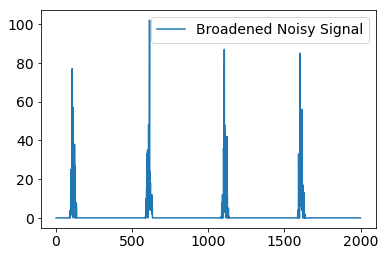

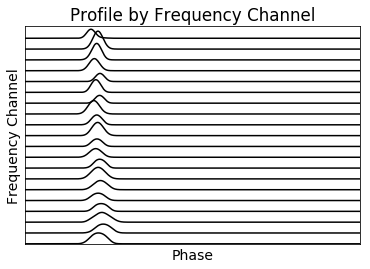

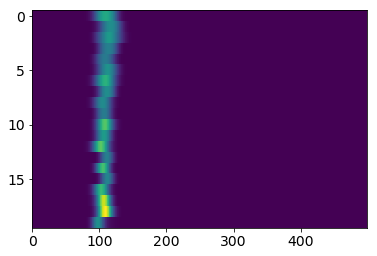

In [20]:
S5=PSS.Signal(Nt=2000,mode='simulate')
P5=PSS.Pulsar(S5)
I5=PSS.ISM(S5,mode='simulate')
I5.finalize_ism()
peak3 = np.random.randn(20*3)*0.01 + 0.2
width3 = abs(np.random.randn(20*3)*0.002 +0.012)
amp3 = np.random.randn(20*3)**2
peak3.resize(20,3)
width3.resize(20,3)
amp3.resize(20,3)
P5.gauss_template(peak=peak3,width=width3,amp=amp3)
DMBroaden(P5,S5)
P5.make_pulses()
plt.plot(P5.signal[5],label="Broadened Noisy Signal")
plt.legend()
plt.show()
ProfilePlot(P5.profile,N=20)
imshow(P5.profile,aspect='auto')